# SIMBA: multiomics data co-embedding (cells, genes, and peaks)

- Last updated: 11/20/2023
- Author: Yang-Joon Kim

Description: SIMBA (from Luca Pinello's lab) uses network graph theory to compute the edges bewteen nodes (cells, genes, or peaks), which enables co-embedding of cells, genes, with peaks (and even TF motifs or k-mers). This can help our annotation of different cell-types, as well as marker genes/peaks for our single-cell multiome datasets from zebrafish.

sample notebook: https://simba-bio.readthedocs.io/en/latest/multiome_shareseq.html

**Specific goals:**
- run SIMBA tutorial with our single-cell multiome datasets (zebrafish, 15-somites stage, TDR119)
- exploratory analyses on marker genes, peaks, using the cell-type annotations transferred from zebrahub.



In [3]:
import os
import simba as si
import scanpy as sc
import pandas as pd
import numpy as np

si.__version__

'1.2'

In [17]:
workdir = '/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/'
si.settings.set_workdir(workdir)

Saving results in: /hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/


In [5]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [7]:
# to make plots prettier
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/tmp/ipykernel_2413484/3381039072.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [8]:
# Load the adata objects
# note that the adata.X count matrices are all "raw" counts
adata_rna = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/TDR119_processed_RNA_tidy.h5ad")
adata_atac = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/TDR119_processed_ATAC.h5ad")

In [12]:
adata_rna

AnnData object with n_obs × n_vars = 13022 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight'
    var: 'features'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna'

In [13]:
adata_atac

AnnData object with n_obs × n_vars = 13022 × 248320
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight'
    var: 'count', 'percentile'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna'

## Step 1. scATAC-seq
### preprocessing

In [14]:
si.pp.filter_peaks(adata_atac, min_n_cells=3)

si.pp.cal_qc_atac(adata_atac)

Before filtering: 
13022 cells, 248320 peaks
Filter peaks based on min_n_cells
After filtering out low-expressed peaks: 
13022 cells, 248320 peaks


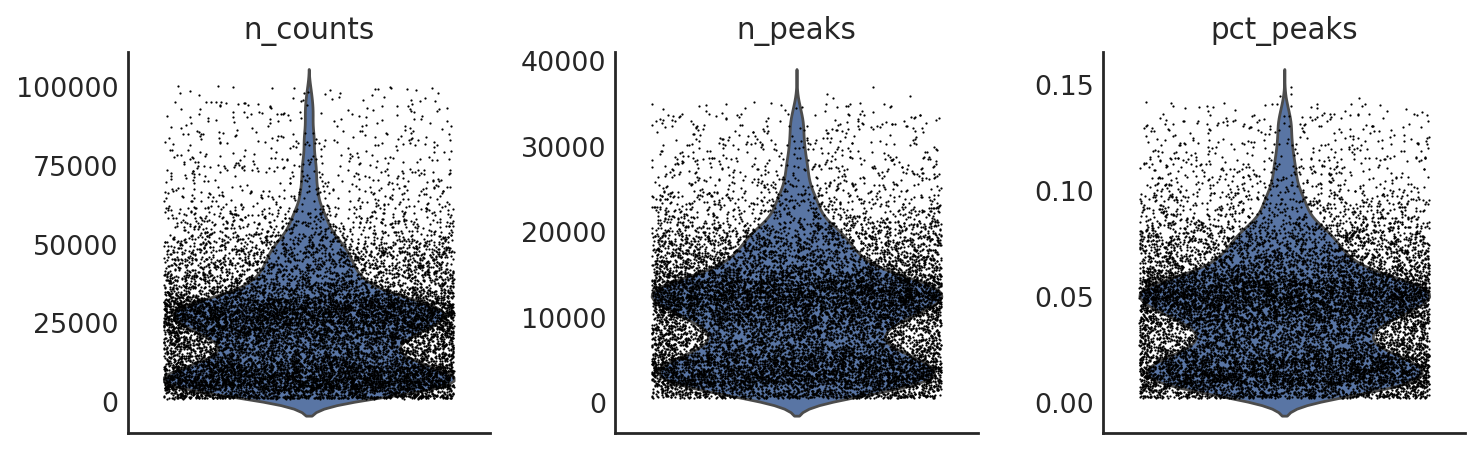

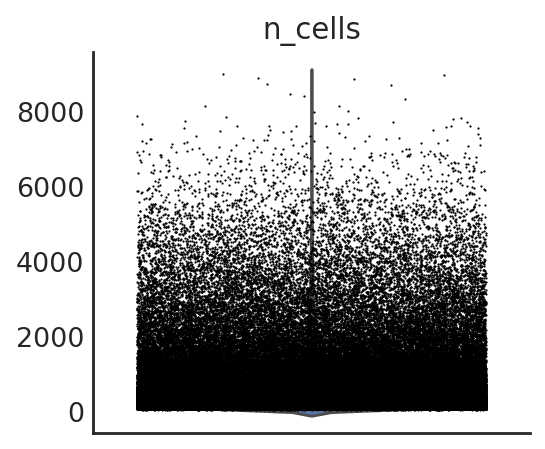

In [15]:
si.pl.violin(adata_atac,list_obs=['n_counts','n_peaks','pct_peaks'], list_var=['n_cells'])

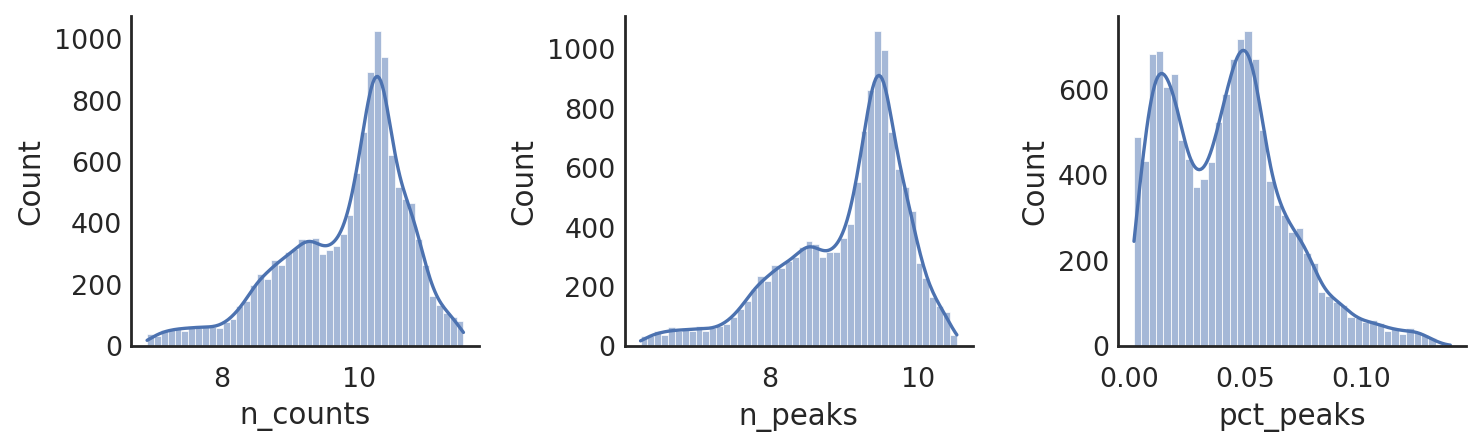

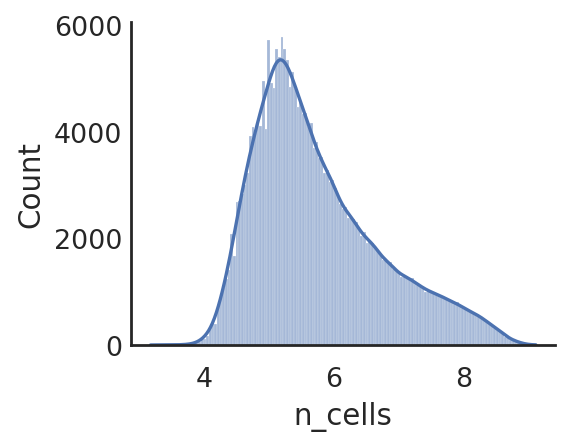

In [16]:
si.pl.hist(adata_atac,list_obs=['n_counts','n_peaks','pct_peaks'], log=True, list_var=['n_cells'])

## Notes:
This seems bimodal, so we'd need to check the cells in low/high n_counts/n_peaks, across cell-types to see if they are low quality cells, or some biological diffrentation between celltypes.

In [ ]:
# select peaks (optional): This will speed up the training process by only keeping peaks associated with top PCs.
si.pp.pca(adata_atac, n_components=40)
si.pl.pca_variance_ratio(adata_atac)
si.pp.select_pcs_features(adata_atac)

## Step 2. scRNA-seq
## Step 2-1. preproecssing


## Notes:

We performed basic QC for this mutliome dataset (both RNA and ATAC), so will not do any further pre-processing here.

## Step 2-2. log-normalize and discretize RNA expression (seems necessary)


In [26]:
# si.pp.filter_genes(adata_rna, min_n_cells=3)

Before filtering: 
13022 cells, 32057 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
13022 cells, 23904 genes


In [28]:
si.pp.cal_qc_rna(adata_rna)

In [29]:
si.pp.normalize(adata_rna,method='lib_size')

In [31]:
si.pp.log_transform(adata_rna)

In [32]:
si.tl.discretize(adata_rna, n_bins=5)

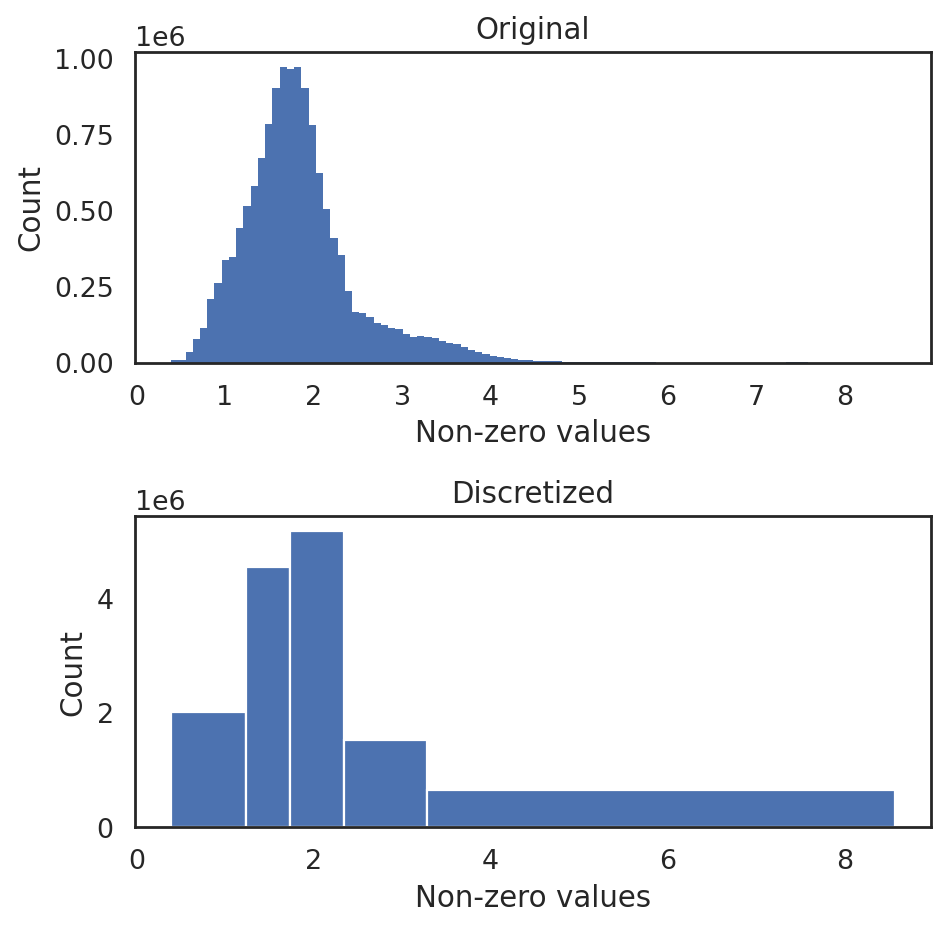

In [33]:
si.pl.discretize(adata_rna, kde=False)

## Step 3. generate graph

In [34]:
si.tl.gen_graph(list_CP=[adata_atac],
                list_CG=[adata_rna],
                copy=False,
                use_highly_variable=False,
                use_top_pcs=False,
                dirname="graph0")

`simba` does not exist in anndata 0 in `list_CP`.`.X` is being used instead.
relation0: source: C, destination: P
#edges: 140940411
relation1: source: C, destination: G
#edges: 2013534
relation2: source: C, destination: G
#edges: 4553977
relation3: source: C, destination: G
#edges: 5190931
relation4: source: C, destination: G
#edges: 1527042
relation5: source: C, destination: G
#edges: 652396
Total number of edges: 154878291
Writing graph file "pbg_graph.txt" to "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/pbg/graph0" ...
Finished.


## Step 4. PBG training

Before PBG trainig, let's take a look at the parameters:

In [35]:
si.settings.pbg_params

{'entity_path': '/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/pbg/graph0/input/entity',
 'edge_paths': ['/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/pbg/graph0/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1},
  'G': {'num_partitions': 1},
  'P': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'P',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 1.0},
  {'name': 'r2', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r5', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epoch

In [36]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.000153
Weight decay being used for training is 0.000153
Converting input data ...
[2023-11-19 16:31:11.341222] Using the 6 relation types given in the config
[2023-11-19 16:31:11.341645] Searching for the entities in the edge files...
[2023-11-19 16:34:11.604174] Entity type C:
[2023-11-19 16:34:11.605014] - Found 13022 entities
[2023-11-19 16:34:11.605500] - Removing the ones with fewer than 1 occurrences...
[2023-11-19 16:34:11.607146] - Left with 13022 entities
[2023-11-19 16:34:11.607421] - Shuffling them...
[2023-11-19 16:34:11.613632] Entity type G:
[2023-11-19 16:34:11.613981] - Found 26272 entities
[2023-11-19 16:34:11.614253] - Removing the ones with fewer than 1 occurrences...
[2023-11-19 16:34:11.616978] - Left with 26272 entities
[2023-11-19 16:34:11.617333] - Shuffling them...
[2023-11-19 16:34:11.630421] Entity type P:
[2023-11-19 16:34:11.630975] - Found 248320 entities
[2023-11-19 16:34:

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/torchbiggraph/tensorlist.py:87: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = data.storage()
/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/torchbiggraph/tensorlist.py:88: UserWarning: TypedStorage is deprecated

[2023-11-19 16:47:10.818929] - Processed 154878291 edges in total
Starting training ...


/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/torchbiggraph/util.py:211: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_type = dummy_tensor.storage_type()
/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/torch/storage.py:959: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if self.device.type not in ['cpu', 'cuda']:
/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/torch/storage.py:962: UserWarning: TypedStorage is deprecated. It will be rem

Finished


Here we show how to adjust training-related parameters if needed. In general, weight decay wd is the only parameter that might need to be adjusted based on the following pbg metric plots. However, in almost all the cases, the automatically decided wd (enabling it by setting auto_wd=True) works well.

E.g. we want to change the number of cpus workers:

In [ ]:
# # modify parameters
# dict_config = si.settings.pbg_params.copy()
# # dict_config['wd'] = 0.000172
# dict_config['workers'] = 8

# ## start training
# si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model')

If wd is specified by users instead of being automatically decided, then make sure to update it in simba setting:

In [ ]:
# si.settings.pbg_params = dict_config.copy()

## Step 5. Load the PBG training result



In [37]:
# load in graph ('graph0') info
si.load_graph_stats()
# load in model info for ('graph0')
si.load_pbg_config()

In [ ]:
# # or, users can specify different paths
# # load in graph ('graph0') info
# si.load_graph_stats(path='./result_multiome_shareseq/pbg/graph0/')
# # load in model info for ('graph0')
# si.load_pbg_config(path='./result_multiome_shareseq/pbg/graph0/model/')

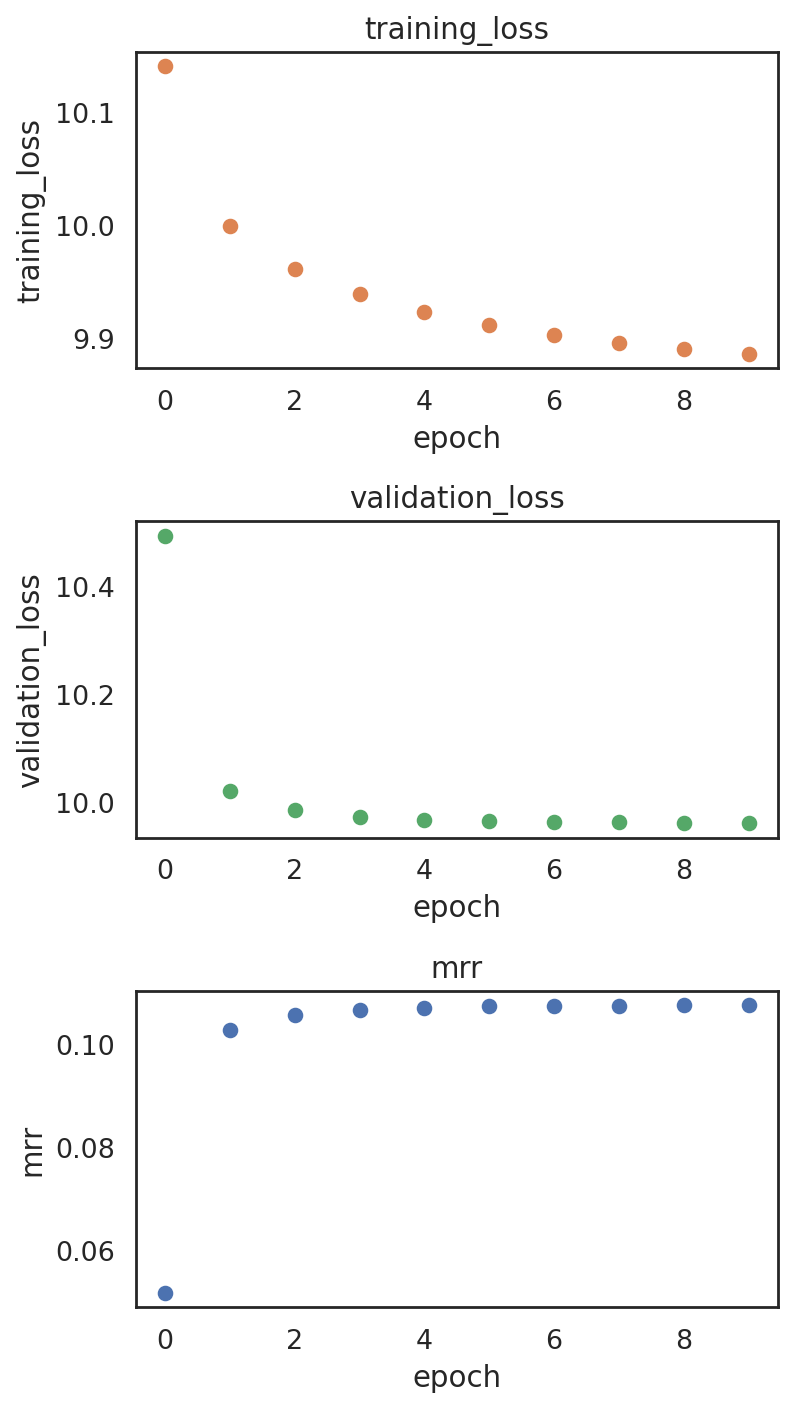

In [38]:
#Plotting training metrics to make sure the model is not overfitting
si.pl.pbg_metrics(fig_ncol=1)

## Step 6. post-training analysis

In [39]:
# extract the master dictionary for all adata objects
dict_adata = si.read_embedding()
dict_adata

{'G': AnnData object with n_obs × n_vars = 26272 × 50,
 'P': AnnData object with n_obs × n_vars = 248320 × 50,
 'C': AnnData object with n_obs × n_vars = 13022 × 50}

In [40]:
# extract embeddings for each modality (feature - cells, genes, or peaks)
adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes
adata_P = dict_adata['P']  # embeddings for peaks
# adata_K = dict_adata['K']  # embeddings for kmers
# adata_M = dict_adata['M']  # embeddings for motifs

# #### to distinguish TF motif names from gene names in this case
# adata_M.obs.index = 'M_'+adata_M.obs.index

In [45]:
# compute 2D embeddings (UMAPs) for each modality (cells, genes, or peaks)
si.tl.umap(adata_C, n_neighbors=15, n_components=2)

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [46]:
adata_C.obs["celltype"] = adata_rna[adata_C.obs_names,:].obs["global_annotation"].copy()
adata_C

AnnData object with n_obs × n_vars = 13022 × 50
    obs: 'celltype'
    obsm: 'X_umap'

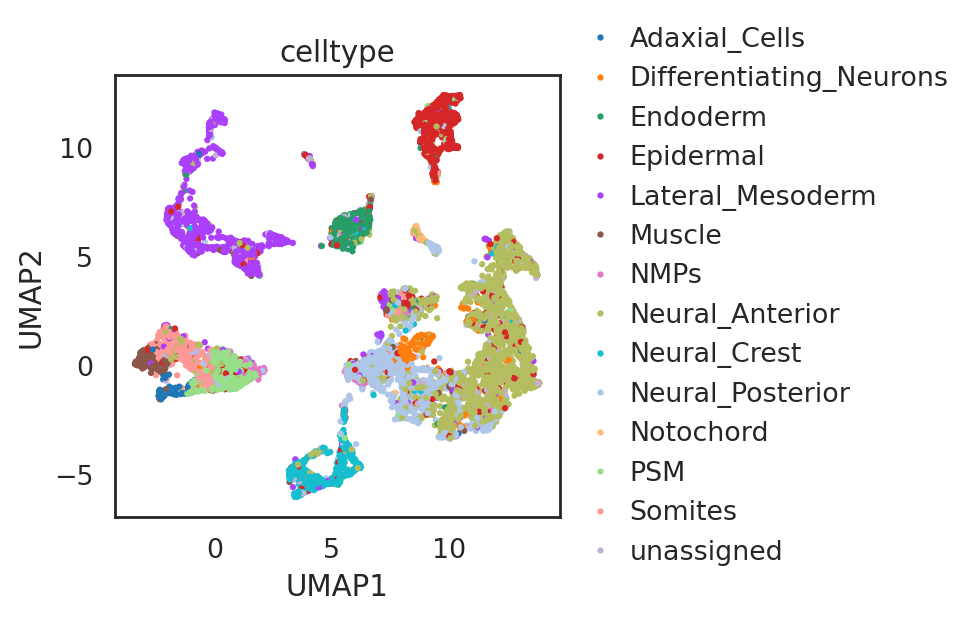

In [47]:
# cell embedding (what is this actually?! a typical UMAP from transcriptomics?)
si.pl.umap(adata_C,
           color=['celltype'],
           fig_size=(6,4),
           drawing_order='random')

### Step 6-2 visualize embeddings of cells and genes


In [50]:
adata_all_CG = si.tl.embed(adata_ref=adata_C,
                           list_adata_query=[adata_G])

Performing softmax transformation for query data 0;


In [51]:
## add annotations of all entities
adata_all_CG.obs['entity_anno'] = ""
adata_all_CG.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all_CG.obs.loc[adata_C.obs_names, 'celltype'].tolist()
adata_all_CG.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'

adata_all_CG.obs.head()

celltype id_dataset       entity_anno
GGTTGAGCAGGTATTT-1   Neural_Anterior        ref   Neural_Anterior
TGTCAATCATGAAATG-1   Neural_Anterior        ref   Neural_Anterior
CCATATTTCTTGGACG-1      Neural_Crest        ref      Neural_Crest
CAAACAACAAGCTAAA-1            Muscle        ref            Muscle
CAGGTCCAGGTCCACA-1  Lateral_Mesoderm        ref  Lateral_Mesoderm

In [52]:
si.tl.umap(adata_all_CG,n_neighbors=15,n_components=2)

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


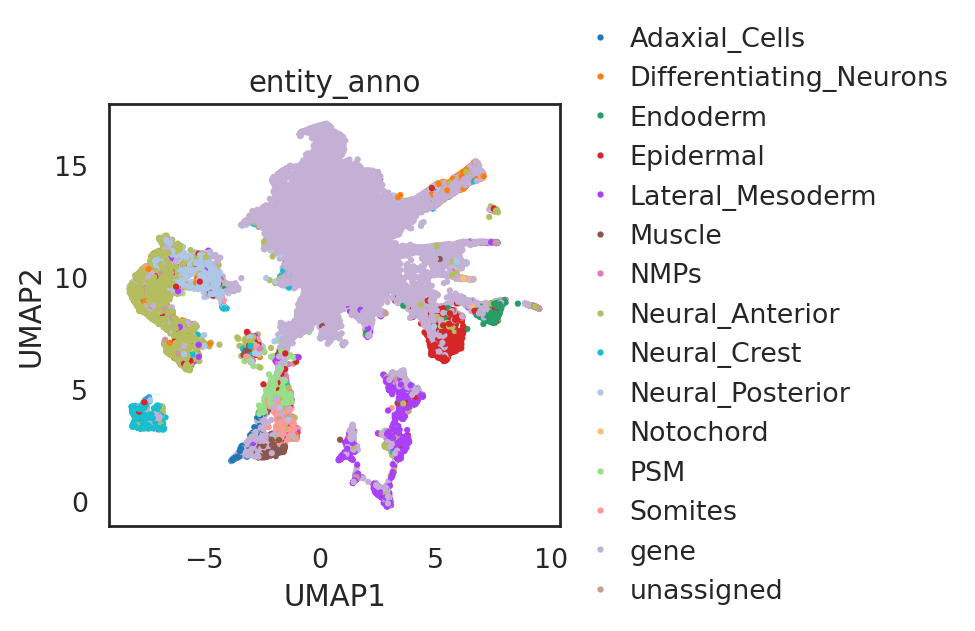

In [53]:
# plotting the cells+genes UMAP
si.pl.umap(adata_all_CG,
           color=['entity_anno'],
           #dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(6,4),
           drawing_order='random')

In [54]:
adata_all_CG

AnnData object with n_obs × n_vars = 39294 × 50
    obs: 'celltype', 'id_dataset', 'entity_anno'
    uns: 'color'
    obsm: 'X_umap'

In [55]:
#some marker genes from the zebrafish study
marker_genes = ['meox1','sox2','tbxta','tbx16','pax6a', 'pax6b','msgn1', 'myl1']

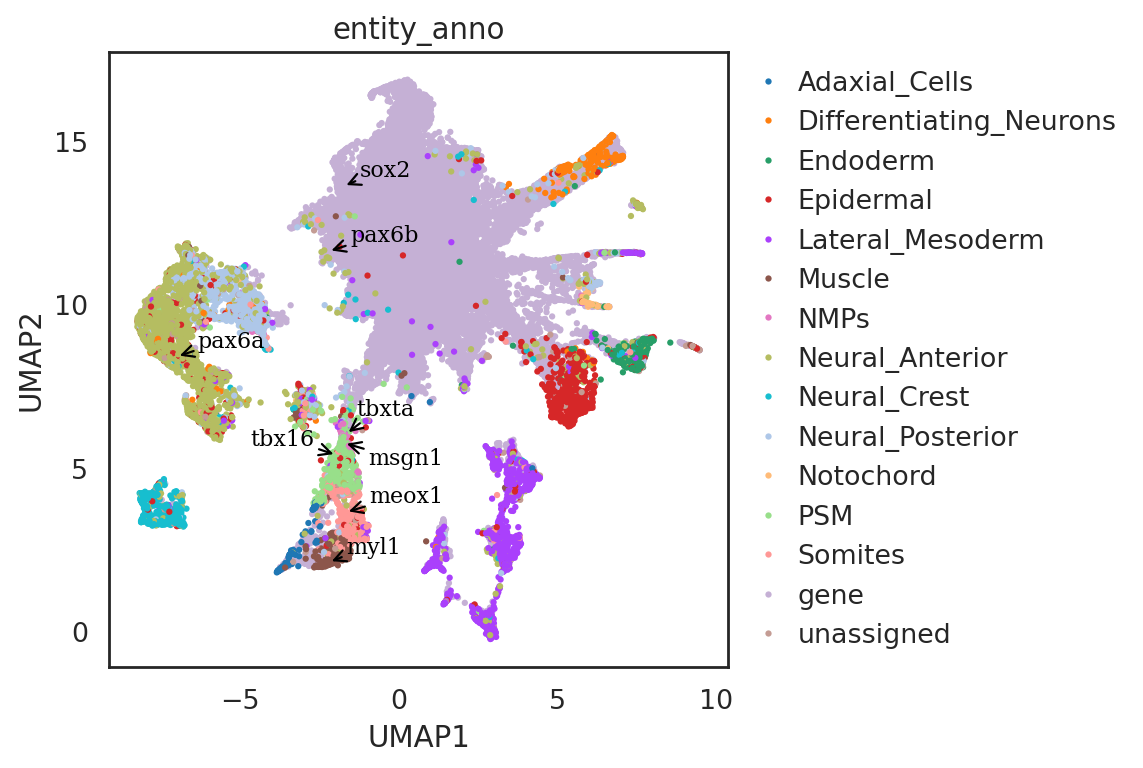

In [56]:
si.pl.umap(adata_all_CG[::-1,],
           color=['entity_anno'],
           #dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(7,5),
           texts=marker_genes,
           text_expand=(2,1.5),
           show_texts=True,
           drawing_order='original')

### Step 6-3. visualize embeddings of all entities including cells, genes, and peaks

In [57]:
adata_all = si.tl.embed(adata_ref=adata_C,
                        list_adata_query=[adata_G, adata_P])

Performing softmax transformation for query data 0;
Performing softmax transformation for query data 1;


In [58]:
## add annotations of all entities
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'celltype'].tolist()
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'
adata_all.obs.loc[adata_P.obs_names, 'entity_anno'] = 'peak'
# adata_all.obs.loc[adata_K.obs_names, 'entity_anno'] = 'kmer'
# adata_all.obs.loc[adata_M.obs_names, 'entity_anno'] = 'motif'

adata_all.obs.head()

celltype id_dataset       entity_anno
GGTTGAGCAGGTATTT-1   Neural_Anterior        ref   Neural_Anterior
TGTCAATCATGAAATG-1   Neural_Anterior        ref   Neural_Anterior
CCATATTTCTTGGACG-1      Neural_Crest        ref      Neural_Crest
CAAACAACAAGCTAAA-1            Muscle        ref            Muscle
CAGGTCCAGGTCCACA-1  Lateral_Mesoderm        ref  Lateral_Mesoderm

In [60]:
si.tl.umap(adata_all,n_neighbors=50,n_components=2,n_jobs=8)

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value 8 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/simba/plotting/_plot.py:1065: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['color'] = dict()


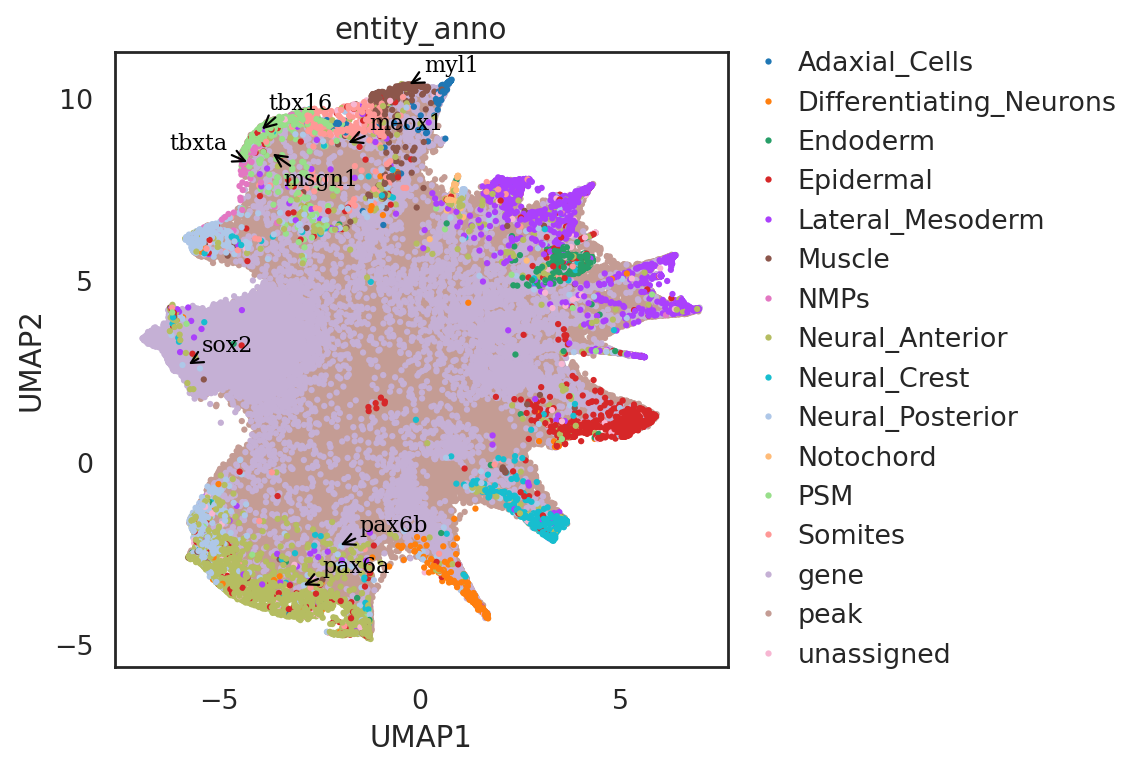

In [61]:
si.pl.umap(adata_all[::-1,],
           color=['entity_anno'],
           #dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(7,5),
           drawing_order='original',
           texts=marker_genes,
           text_expand=(2,2),
           show_texts=True)

In [158]:
adata_C.obs_names

Index(['GGTTGAGCAGGTATTT-1', 'TGTCAATCATGAAATG-1', 'CCATATTTCTTGGACG-1',
       'CAAACAACAAGCTAAA-1', 'CAGGTCCAGGTCCACA-1', 'GTGAATCTCCTTAGGG-1',
       'ATTGCTCGTTAGTACG-1', 'ACCAGGGAGACTAAGG-1', 'AGGTCCGGTGTGTCCC-1',
       'CTCTATGTCCAGGTCA-1',
       ...
       'AACATAGCATCATGTG-1', 'CGAAGCGAGCTTAGTA-1', 'TTTGCATTCATCACTT-1',
       'GAGTAATAGTAAGAAC-1', 'ACCTGTTGTGTGTGGT-1', 'CCACTTGGTAGCTGCG-1',
       'GAACTTATCTTAGTGA-1', 'TCGTTAGCACTGACCG-1', 'CGTAGCGGTTAAGCTG-1',
       'GCATATATCAGCACCA-1'],
      dtype='object', length=13022)

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/simba/plotting/_plot.py:1065: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['color'] = dict()


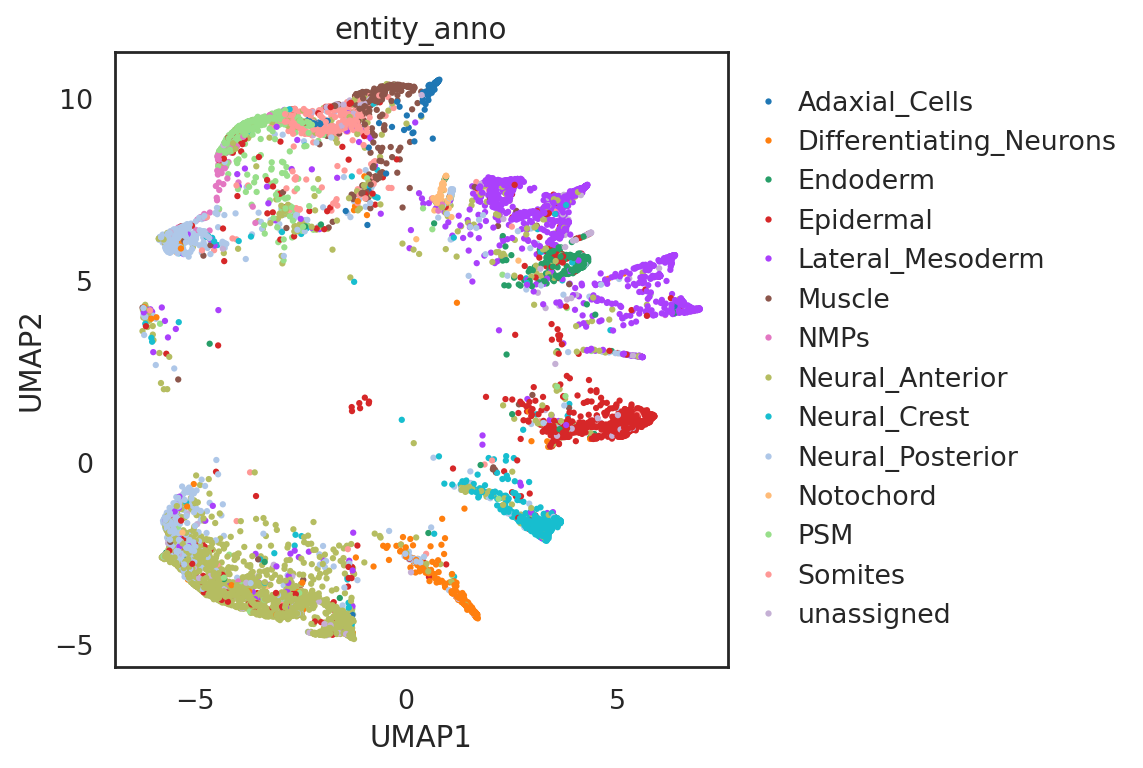

In [160]:
# only cells are shown
si.pl.umap(adata_all[adata_C.obs_names,:],
           color=['entity_anno'],
           #dict_palette={'entity_anno': palette_entity_anno},
           fig_size=(7,5),
           drawing_order='original',
           #texts=marker_genes,
           text_expand=(2,2),
           show_texts=True)

### SIMBA metrics (what is this??)

In [62]:
# genes
adata_cmp_CG = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_G)

# peaks
adata_cmp_CP = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_P)

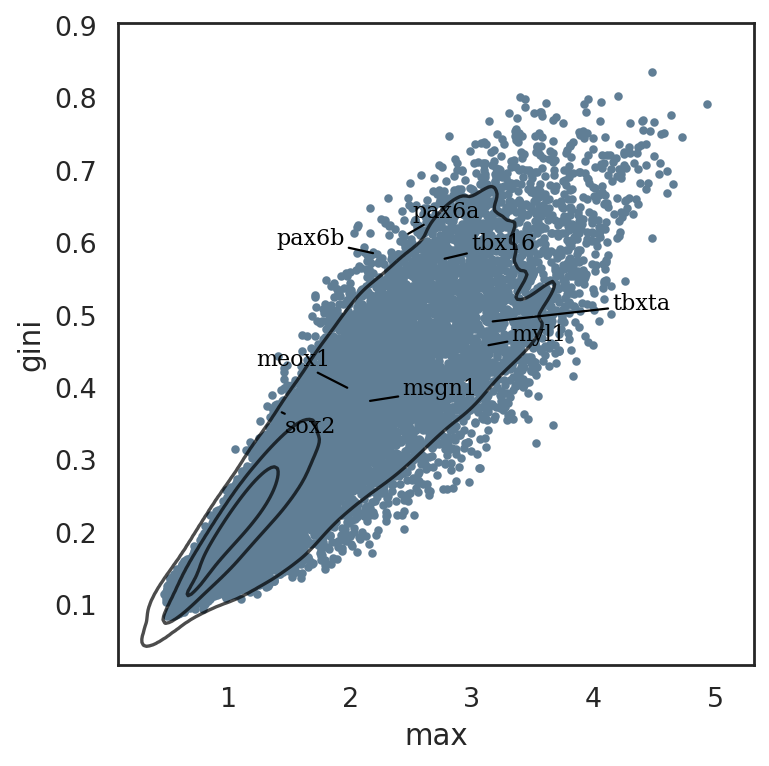

In [64]:
# plot the entityr metrics (cells and genes)
si.pl.entity_metrics(adata_cmp_CG,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=False,
                     show_contour=True,
                     c='#607e95',
                     texts=marker_genes,
                     text_expand=(2,1.5))

In [99]:
adata_cmp_CG[:,adata_cmp_CG.var_names=="sox2"].var

max       std      gini   entropy
sox2  1.403012  0.707992  0.368362  9.257748

In [71]:
adata_cmp_CG.var

max       std      gini   entropy
adgrg1          2.194425  0.867490  0.470385  9.084120
arl1            0.915159  0.318261  0.178416  9.423643
prokr1a         1.229435  0.446683  0.254128  9.370776
AL845369.1      0.871751  0.261057  0.150686  9.436016
LO017650.1      1.405739  0.431011  0.250494  9.365180
...                  ...       ...       ...       ...
prl2            1.586991  0.414013  0.246683  9.358869
terb1           1.026348  0.311377  0.179920  9.420329
foxo3b          1.955124  0.644415  0.354609  9.249593
CCKAR           2.631392  0.640756  0.412642  9.059643
CABZ01045212.1  1.347916  0.527731  0.281838  9.344652

[26272 rows x 4 columns]

In [72]:
df_CG = adata_cmp_CG.var
df_CG

max       std      gini   entropy
adgrg1          2.194425  0.867490  0.470385  9.084120
arl1            0.915159  0.318261  0.178416  9.423643
prokr1a         1.229435  0.446683  0.254128  9.370776
AL845369.1      0.871751  0.261057  0.150686  9.436016
LO017650.1      1.405739  0.431011  0.250494  9.365180
...                  ...       ...       ...       ...
prl2            1.586991  0.414013  0.246683  9.358869
terb1           1.026348  0.311377  0.179920  9.420329
foxo3b          1.955124  0.644415  0.354609  9.249593
CCKAR           2.631392  0.640756  0.412642  9.059643
CABZ01045212.1  1.347916  0.527731  0.281838  9.344652

[26272 rows x 4 columns]

In [74]:
df_CG_sorted = df_CG.sort_values("max", ascending=False)
df_CG_sorted.head(20)

max       std      gini   entropy
slc2a1a             4.935772  0.718058  0.792124  6.169481
myom1a              4.724298  0.837925  0.745434  7.025860
npr1b               4.652431  0.746947  0.681220  7.295843
cntnap5a            4.638766  0.901212  0.775974  6.907899
baiap2l2a           4.607091  0.739743  0.668473  7.455066
alpk3b              4.604627  0.783948  0.698414  7.356000
snap25a             4.584197  0.841295  0.751830  7.086616
si:dkey-178k16.1    4.553308  0.836051  0.749805  7.097948
myom1b              4.549613  0.836472  0.710030  7.419855
si:ch211-266g18.10  4.543050  0.805172  0.695196  7.468637
BX571827.3          4.501737  0.955620  0.767212  7.237629
spegb               4.497796  0.844314  0.719318  7.400257
ryr2b               4.483808  1.133609  0.835557  6.967350
AL929208.1          4.478373  0.637591  0.606403  7.657164
vgll2b              4.464514  0.927430  0.753773  7.122892
scospondin          4.451270  0.848562  0.681821  7.662898
scn8aa              4.435541  0.840175  0.707936  7.483015
onecut3b            4.432009  0.890175  0.736214  7.388241
CR589876.1          4.429516  0.790263  0.674776  7.655370
flt1                4.408750  0.886679  0.769619  7.182103

In [ ]:
# plot the entityr metrics (cells and peaks) - NOTE that this is not helpful unless we annotate the peaks to "genes" using TSS
# we can actually do this using the cicero/celloracle result - annotating only the peaks associated with genes (TSS)

# si.pl.entity_metrics(adata_cmp_CP,
#                      x='max',
#                      y='gini',
#                      show_texts=True,
#                      show_cutoff=False,
#                      show_contour=False,
#                      texts=['Peak1(Lef1)', 'Peak2(Lef1)', 'Peak3(Lef1)', 'Peak4(Lef1)',
#                             'Peak1(Hoxc13)', 'Peak2(Hoxc13)'],
#                      text_expand=(2,1.5),
#                      c='#e5c2c8')

## Step 7. only visulize the embeddings of cells and cell-type specific features

In [108]:
# marker genes from zebrahub (15somites - from Merlin)
list_marker_genes_15somites = ["lrrc17", "comp", "ripply1", # somite
"rx1","vsx2", # optic vesicle
"tbx16","myf5","hes6", # paraxial_mesoderm
"crestin","ednrab","dlx2a", # neural_crest
"fezf1","sox1b","foxg1a", # telencephalon
"cldni","cfl1l", # periderm
"olig3","hoxd4a","rxrga", # spinal_cord_neural_tube
"gata5","myh7","tnnt2a", # heart
"pkd1b","scg3", # neural_tube
"etv5a","pitx3", # lens_placode
"elavl3","stmn1b","sncb", # trigeminal_placode
"myog","myl1","jam2a", # myotome
"prrx1","nid1b", # head_mesenchyme
"cpox","gata1a","hbbe1", # hematopoetic_system
"unc45b","ttn1","apobec2a", # adaxial_cell
"foxi3b","atp1b1b", # ectoderm_cell
"fli1b","kdrl", # lateral_mesoderm
"anxa4","cldnc","cldn15a", # pronephros
"tbx3b","loxl5b","emilin3a", # notochord
"sema3aa","irx7","vegfaa", # brain
"ppl","krt17","icn2", # periderm
"osr1","hand2", # lateral_mesoderm
"shha","shhb","foxa2", # floor_plate
"cebpa","spi1b","myb", # myeloid_progenitor
"ctslb","surf4l","sec61a1l", # hatching_gland
"mcf2lb","bricd5", #optic_placode
"etnk1","chd17","acy3"] #pronephros

In [143]:
list_marker_genes_15somites = [gene for gene in list_marker_genes_15somites if gene not in missing_genes_from_RNA]

In [112]:
len(list_marker_genes_15somites)

74

In [123]:
"hes6" in gene_selected

True

In [166]:
genes_filtered = adata_cmp_CG.var[(adata_cmp_CG.var['max']>2) & (adata_cmp_CG.var['gini']>0.4)].index.tolist()
genes_selected = list(set(genes_filtered) | set(list_marker_genes_15somites) | set(marker_genes))
len(genes_selected)

3396

In [167]:
# NOTE: The five genes were missing from our adata_all - likely because they were expressed at a very low level in our scRNA-seq dataset.
missing_genes_from_RNA = ['prrx1', 'hbbe1', 'chd17', 'ttn1', 'acy3']

genes_selected = [gene for gene in genes_selected if gene not in missing_genes_from_RNA]
len(genes_selected)

3396

In [ ]:
# # The union of top 1000 neighbor peaks of all marker genes and TF motifs
# query_result = si.tl.query(adata_all,
#                            obsm=None,
#                            entity=marker_genes + ['TF_Lef1','TF_Hoxc13'],
#                            k=1000,use_radius=False,
#                            anno_filter='entity_anno',
#                            filters=['peak'])
# print(query_result.shape)
# query_result.head()
# peaks_selected = list(query_result.index.unique())
# len(peaks_selected)

In [168]:
adata_all_selected = adata_all[adata_C.obs_names.to_list()
                               + genes_selected, ].copy()
                               #+ motifs_selected
                               #+ peaks_selected, ].copy()
adata_all_selected

AnnData object with n_obs × n_vars = 16418 × 50
    obs: 'celltype', 'id_dataset', 'entity_anno'
    obsm: 'X_umap'

In [171]:
si.tl.umap(adata_all_selected,n_neighbors=50,n_components=2, random_state=0)

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [90]:
#some marker genes from the zebrafish study
marker_genes = ["sox2","meox1","msgn1",'tbxta','tbx16','pax6a', 'pax6b', 'myl1']

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/simba/plotting/_plot.py:1065: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['color'] = dict()


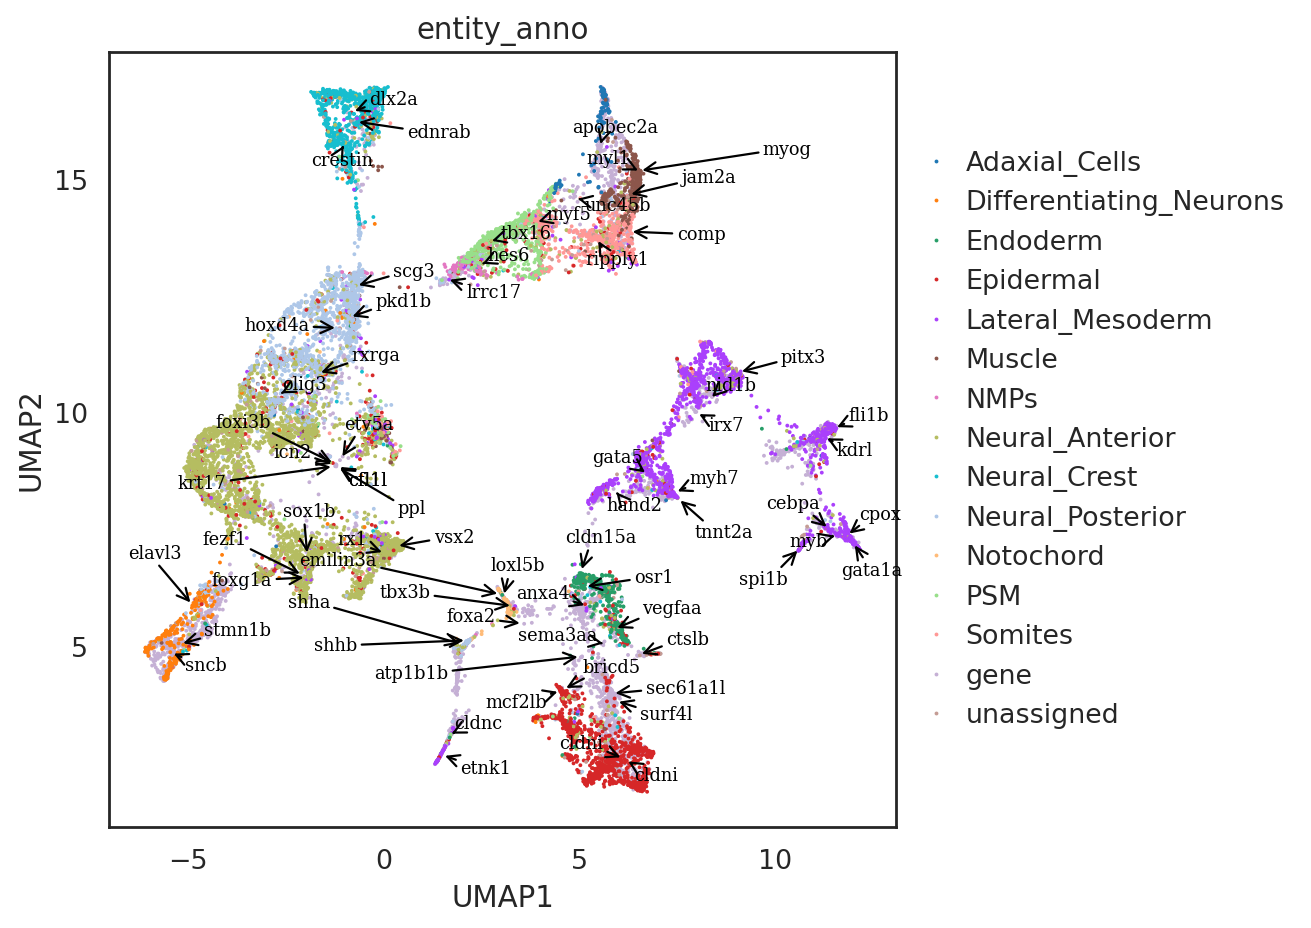

In [173]:
si.pl.umap(adata_all_selected[::-1,],
           color=['entity_anno'],
           #dict_palette={'entity_anno': palette_entity_anno},
           text_size=8,
           fig_size=(8,6),
           size=3,
           drawing_order='original',
           texts=list_marker_genes_15somites,
           #texts=marker_genes \
           #      + ['TF_Lef1','TF_Hoxc13'] \
           #      + ['Peak1(Lef1)', 'Peak2(Lef1)', 'Peak3(Lef1)', 'Peak4(Lef1)',
           #         'Peak1(Hoxc13)', 'Peak2(Hoxc13)'],
           text_expand=(2,1.5),
           show_texts=True)

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/simba/plotting/_plot.py:1065: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['color'] = dict()


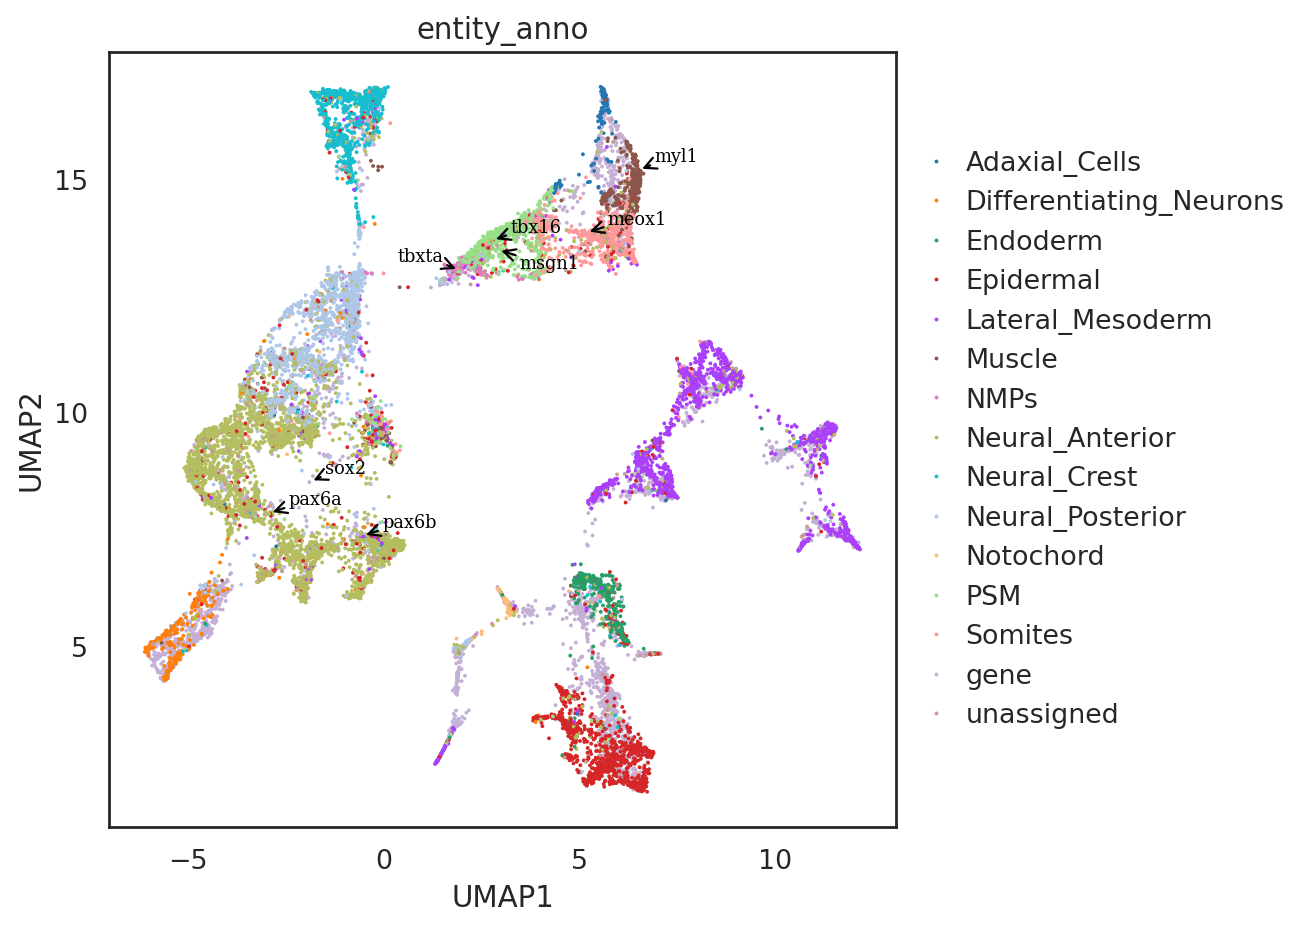

In [172]:
si.pl.umap(adata_all_selected[::-1,],
           color=['entity_anno'],
           #dict_palette={'entity_anno': palette_entity_anno},
           text_size=8,
           fig_size=(8,6),
           size=3,
           drawing_order='original',
           texts=marker_genes,
           #texts=marker_genes \
           #      + ['TF_Lef1','TF_Hoxc13'] \
           #      + ['Peak1(Lef1)', 'Peak2(Lef1)', 'Peak3(Lef1)', 'Peak4(Lef1)',
           #         'Peak1(Hoxc13)', 'Peak2(Hoxc13)'],
           text_expand=(2,1.5),
           show_texts=True)

## Step 8. save the adata objects

This is where we need some creativity - how can we save the object with all embeddings?

- First, adata_all should be the major object.
- Second, we will concatenate "0"s for other embeddings.



celltype id_dataset entity_anno
pif1        NaN    query_0        gene
bicc1a      NaN    query_0        gene
vwa2        NaN    query_0        gene
bmp16       NaN    query_0        gene
ccl25b      NaN    query_0        gene

In [180]:
adata_P

AnnData object with n_obs × n_vars = 248320 × 50
    layers: 'softmax'

In [ ]:
# adata_CG.write(os.path.join(workdir,'adata_CG.h5ad'))
# adata_CP.write(os.path.join(workdir,'adata_CP.h5ad'))

adata_C.write(os.path.join(workdir,'adata_C.h5ad'))
adata_G.write(os.path.join(workdir,'adata_G.h5ad'))
adata_P.write(os.path.join(workdir,'adata_P.h5ad'))

adata_all_CG.write(os.path.join(workdir,'adata_all_CG.h5ad'))
adata_all.write(os.path.join(workdir,'adata_all.h5ad'))
adata_all_selected.write(os.path.join(workdir,'adata_all_selected.h5ad'))

adata_cmp_CG.write(os.path.join(workdir,'adata_cmp_CG.h5ad'))
adata_cmp_CP.write(os.path.join(workdir,'adata_cmp_CP.h5ad'))

In [191]:
adata_all.obsm["X_umap"]

array([[-5.339795 , -2.8018823],
       [-1.2943472, -4.756415 ],
       [ 3.082961 , -1.5511141],
       ...,
       [ 0.6766863,  0.6265139],
       [-0.4490059,  7.172708 ],
       [ 6.9376016,  4.1495633]], dtype=float32)

In [195]:
df_umap_features = pd.DataFrame(index=adata_C.obs_names,
                                data=adata_C.obsm["X_umap"])

df_umap_features

0          1
GGTTGAGCAGGTATTT-1   9.649376  -0.973638
TGTCAATCATGAAATG-1  12.664702   5.454842
CCATATTTCTTGGACG-1   4.582353  -5.283343
CAAACAACAAGCTAAA-1  -2.849512   0.520217
CAGGTCCAGGTCCACA-1   0.832015   5.340625
...                       ...        ...
CCACTTGGTAGCTGCG-1   5.111465   5.941409
GAACTTATCTTAGTGA-1   9.483417  12.017977
TCGTTAGCACTGACCG-1   9.203169   9.881030
CGTAGCGGTTAAGCTG-1  10.117153  -0.841708
GCATATATCAGCACCA-1  12.252503  -1.374308

[13022 rows x 2 columns]

In [211]:
# Re-format the UMAPs from each combination of feature sets for adata_all (cells+genes+peaks)
def reformat_umaps(adata, adata_all, embedding_key):
# adata: adata with specific features
# adata_all: the main adata object where we will add the reformatted embeddings
# embedding_key: key to be added in the main adata_all object's obsm slot

    df_umap_features = pd.DataFrame(data=adata.obsm["X_umap"],
                                    index=adata.obs_names,
                                    columns=["UMAP1","UMAP2"])

    df_umap_all = pd.DataFrame(data = np.full((adata_all.n_obs, 2), -10), #data=np.zeros((adata_all.n_obs, 2)),
                               index=adata_all.obs_names,
                               columns=["UMAP1","UMAP2"])

    # mapping the df_umap_features' (x,y) coordinates to df_umap_all for matching entries (df.map?)
    # Update the UMAP coordinates for the entries that are present in both dataframes
    df_umap_all.update(df_umap_features)
    df_umap_all
    # Now df_umap_all contains the UMAP coordinates for cells from adata_C and (0,0) for genes and peaks

    # To store this back into the AnnData object:
    adata_all.obsm[embedding_key] = df_umap_all.values
    
    return adata_all

In [212]:
adata_all_copied = reformat_umaps(adata_C, adata_all, "X_umap_cells")
adata_all_copied = reformat_umaps(adata_all_CG, adata_all, "X_umap_cells_genes")
adata_all_copied = reformat_umaps(adata_all_selected, adata_all, "X_umap_cells_genes_selected")
adata_all_copied

AnnData object with n_obs × n_vars = 287614 × 50
    obs: 'celltype', 'id_dataset', 'entity_anno'
    uns: 'entity_anno_colors'
    obsm: 'X_umap', 'X_umap_cells', 'X_umap_cells_genes', 'X_umap_cells_genes_selected'

In [213]:
adata_all_copied.write_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/TDR119_simba_cells_genes_peaks_embeddings_v2.h5ad")

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


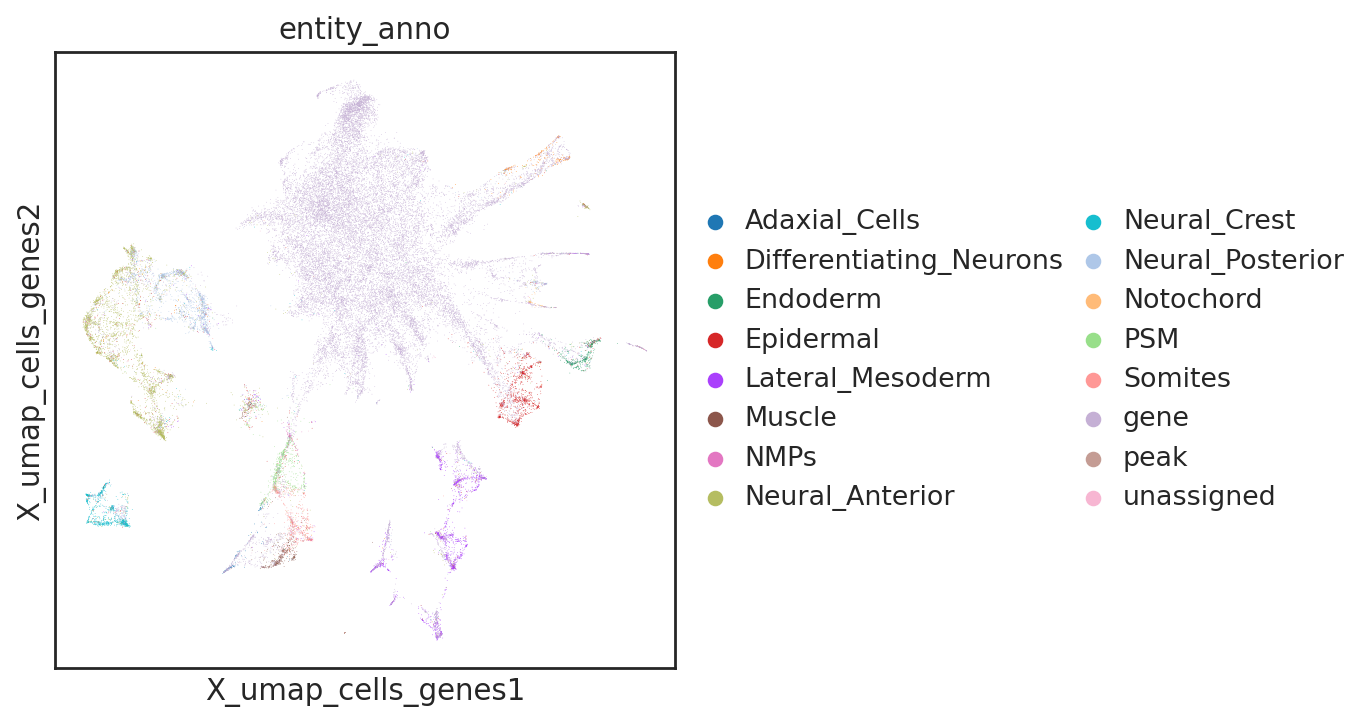

In [201]:
sc.pl.embedding(adata_all_copied, basis="X_umap_cells_genes", color="entity_anno")

# DEPRECATED

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


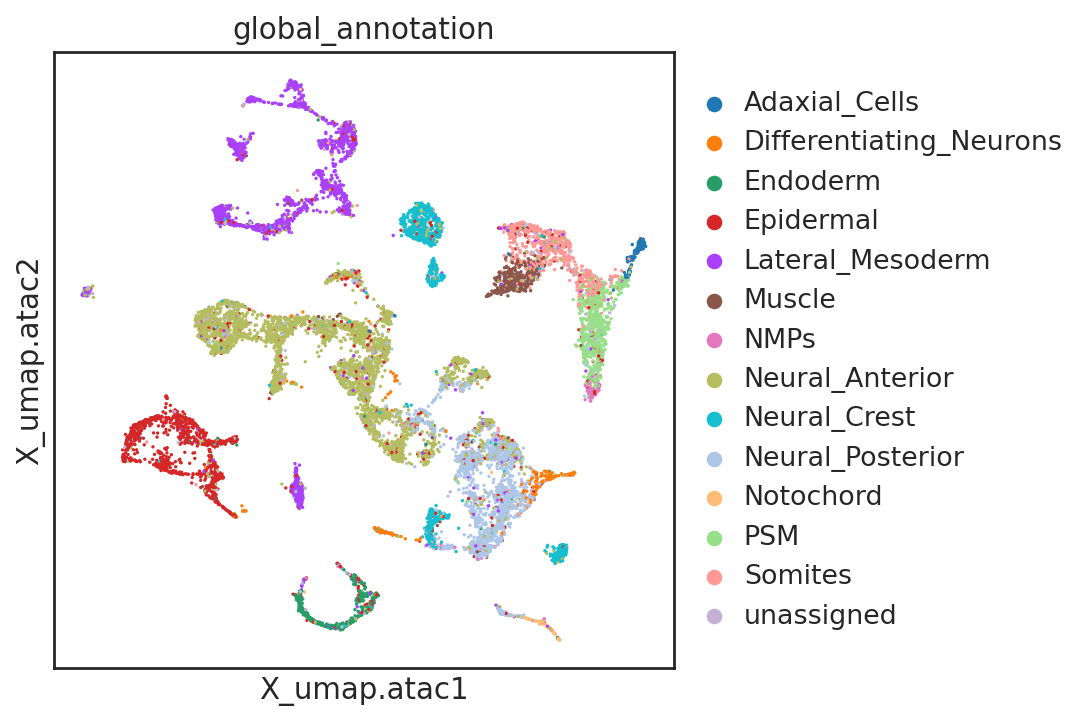

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


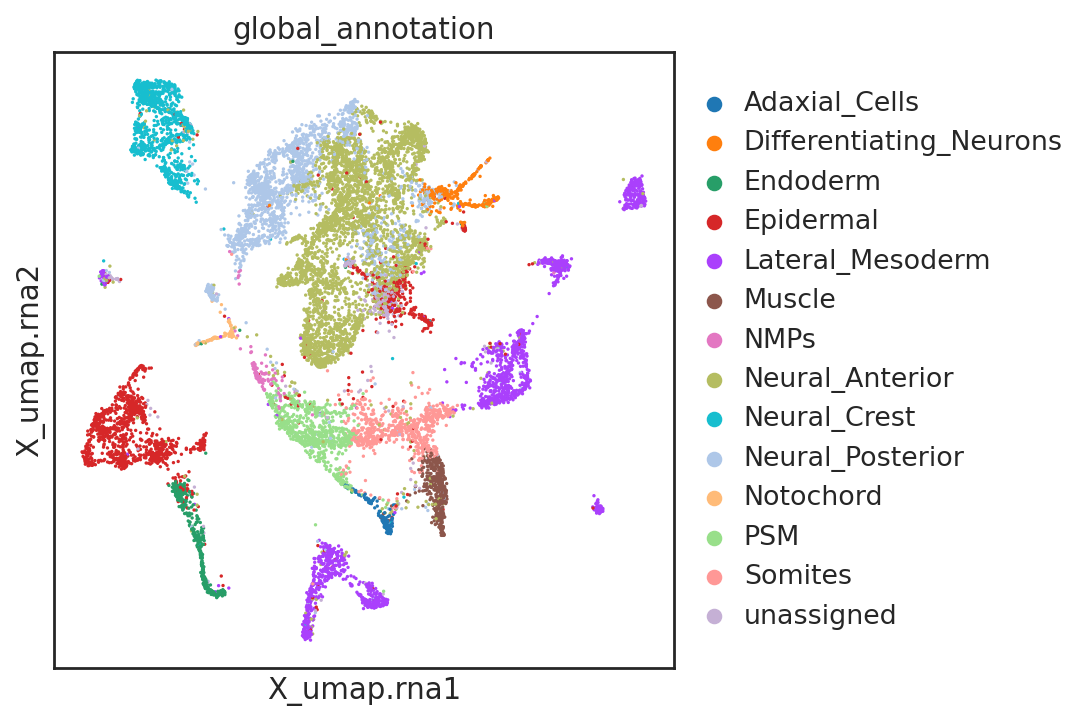

/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yang-joon.kim/.conda/envs/env_simba/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


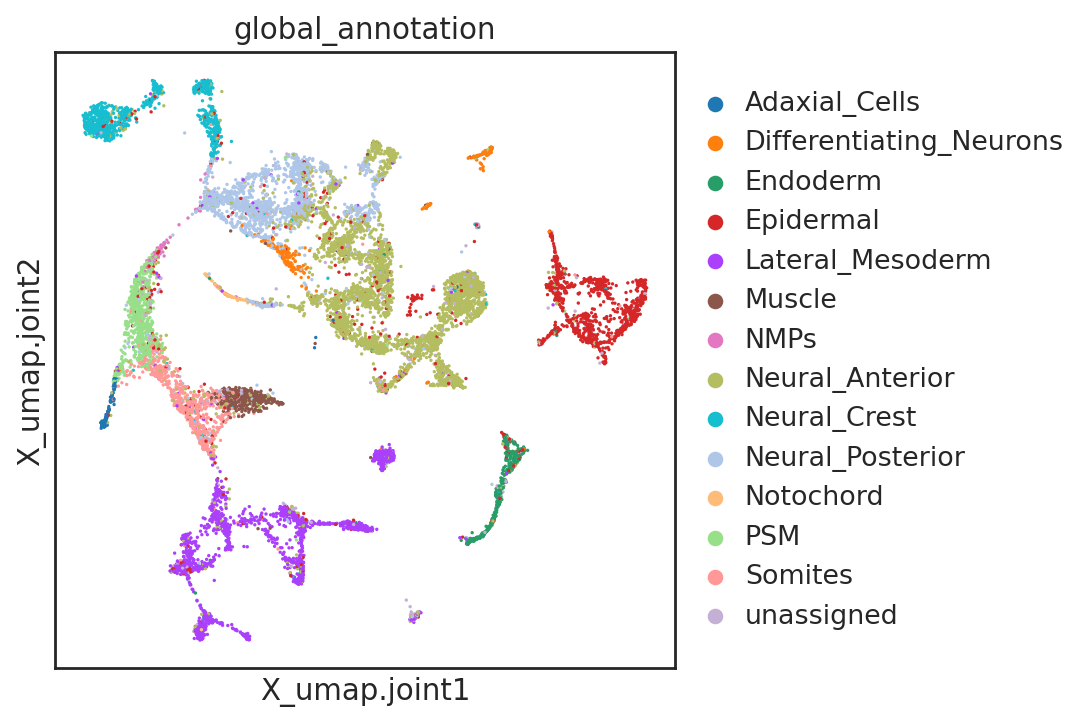

In [49]:
# Check the multiome embeddings (RNA, ATAC, and joint)
sc.pl.embedding(adata_rna, 
                basis="X_umap.atac",
                color="global_annotation")

sc.pl.embedding(adata_rna, 
                basis="X_umap.rna",
                color="global_annotation")

sc.pl.embedding(adata_rna, 
                basis="X_umap.joint",
                color="global_annotation")